In [ ]:
!pip install catboost
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [ ]:
# Импорт данных
df = pd.read_csv('flight_delays_train.csv')
df_test = pd.read_csv('flight_delays_test.csv')
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


# Преобразование и разведочный анализ данных (EDA)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


Пропущенных значений в данных не обнаружено.

In [ ]:
# Проверим датасет на повторные записи
print(df.duplicated().sum())
print(df_test.duplicated().sum())

0
0


Повторные записи отсутствуют.

In [ ]:
df.dep_delayed_15min.value_counts(normalize=True)

,proportion
dep_delayed_15min,
N,0.80956
Y,0.19044


19% выборки составляют задержанные рейсы

In [ ]:
# Заменим месяц, день и день недели на целочисленные значения
df.Month = df.Month.apply(lambda x: int(x[2:]))
df.DayofMonth = df.DayofMonth.apply(lambda x: int(x[2:]))
df.DayOfWeek = df.DayOfWeek.apply(lambda x: int(x[2:]))

df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y


In [ ]:
df_test.Month = df_test.Month.apply(lambda x: int(x[2:]))
df_test.DayofMonth = df_test.DayofMonth.apply(lambda x: int(x[2:]))
df_test.DayOfWeek = df_test.DayOfWeek.apply(lambda x: int(x[2:]))



df_test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,7,25,3,615,YV,MRY,PHX,598
1,4,17,2,739,WN,LAS,HOU,1235
2,12,2,7,651,MQ,GSP,ORD,577
3,3,25,7,1614,WN,BWI,MHT,377
4,6,6,3,1505,UA,ORD,STL,258


In [ ]:
# Закодируем таргет
df.dep_delayed_15min = df.dep_delayed_15min.apply(lambda x: 1 if x == 'Y' else 0)
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,0
1,4,20,3,1548,US,PIT,MCO,834,0
2,9,2,5,1422,XE,RDU,CLE,416,0
3,11,25,6,1015,OO,DEN,MEM,872,0
4,10,7,6,1828,WN,MDW,OMA,423,1


<Axes: xlabel='UniqueCarrier', ylabel='count'>

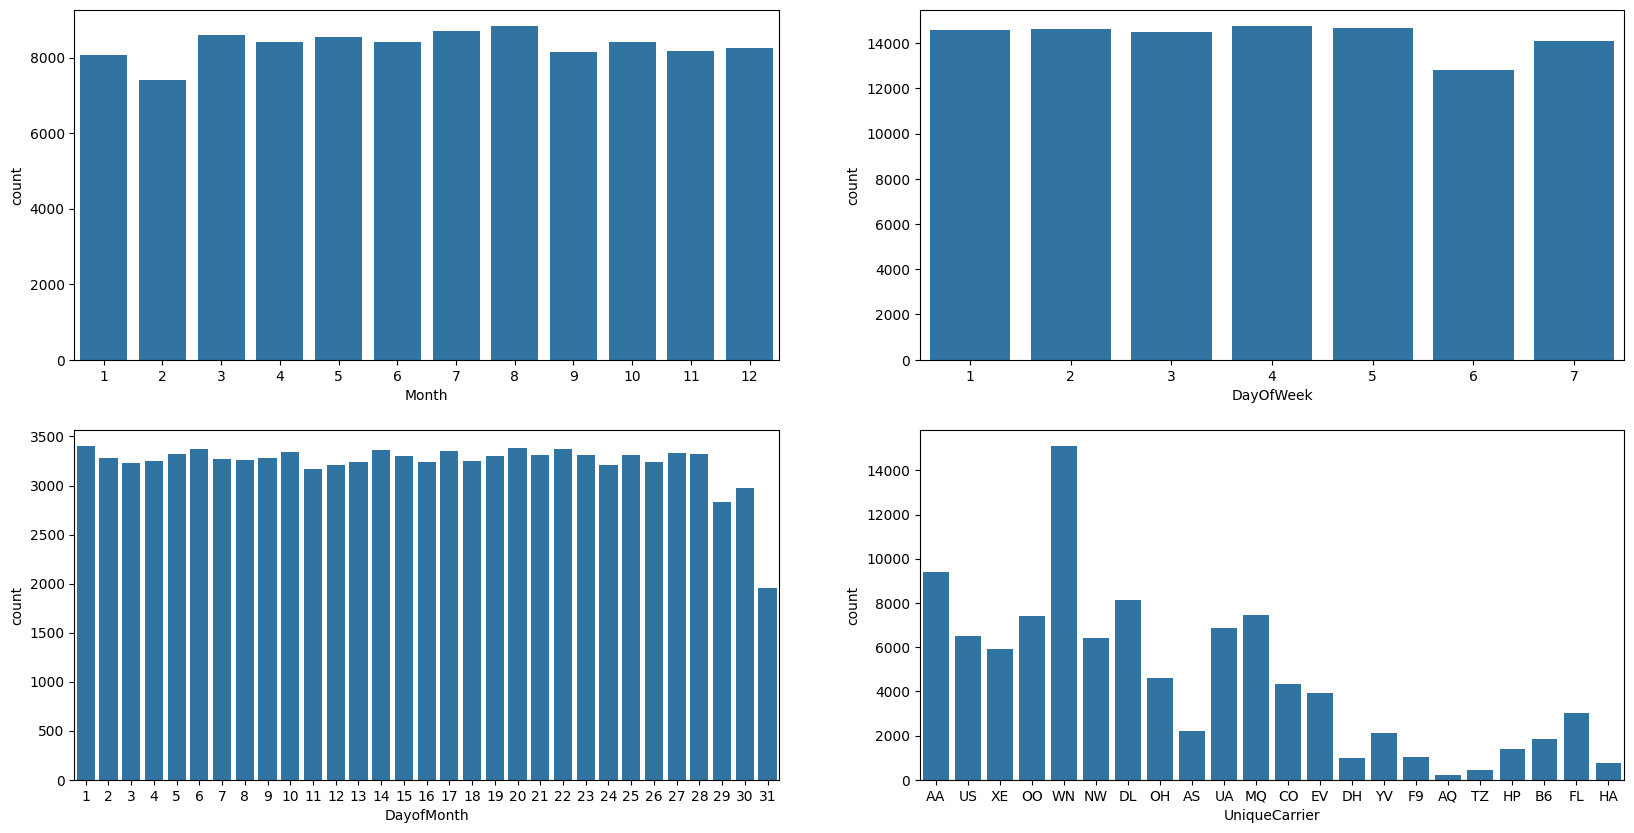

In [ ]:
# Построим графики количества записей в зависимости от признаков
fig, ax = plt.subplots(2, 2, figsize=(20,10))
sns.countplot(x=df.Month, ax=ax[0][0])
sns.countplot(x=df.DayOfWeek, ax=ax[0][1])
sns.countplot(x=df.DayofMonth, ax=ax[1][0])
sns.countplot(x=df.UniqueCarrier, ax=ax[1][1])

В месяце, дне и дне недели закономерностей не обнаружено. Самым часто встречающимся перевозчиком является WN. Самым редко встречающимся - AQ.

Text(0.5, 1.0, 'Количество задержанных полетов и нет от дня недели полета')

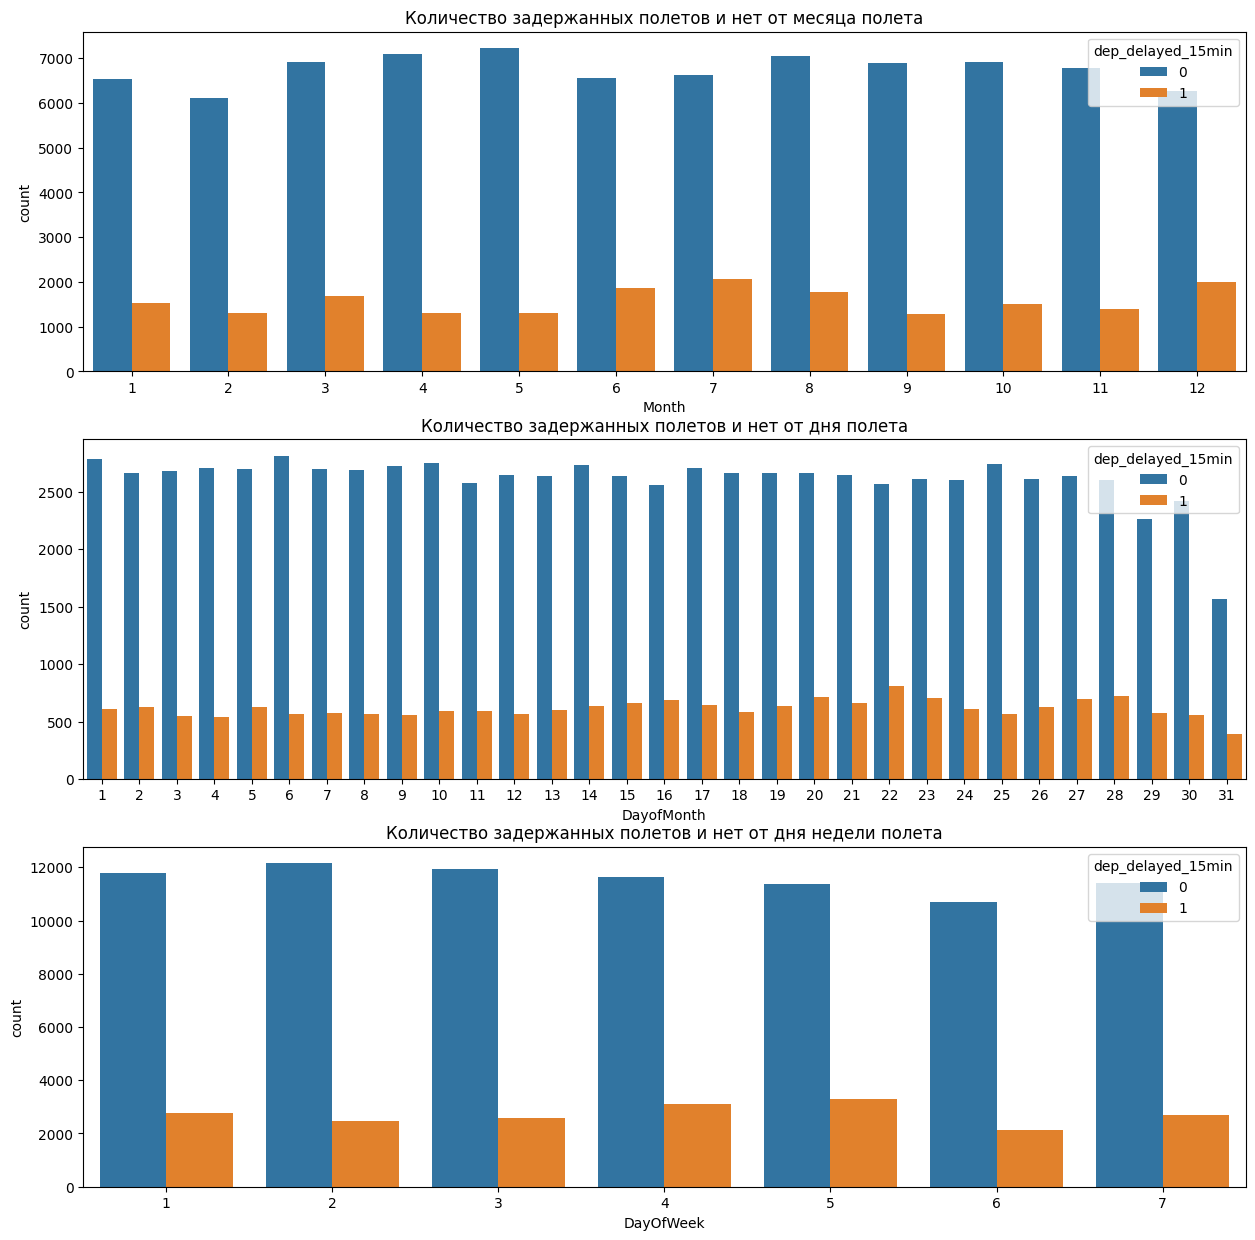

In [ ]:
# Построим графики для поиска зависимостей задержек рейсов от признаков
fig, ax = plt.subplots(3, 1, figsize=(15,15))
sns.countplot(x=df.Month, hue=df.dep_delayed_15min, ax=ax[0])
ax[0].set_title('Количество задержанных полетов и нет от месяца полета')
sns.countplot(x=df.DayofMonth, hue=df.dep_delayed_15min, ax=ax[1])
ax[1].set_title('Количество задержанных полетов и нет от дня полета')
sns.countplot(x=df.DayOfWeek, hue=df.dep_delayed_15min, ax=ax[2])
ax[2].set_title('Количество задержанных полетов и нет от дня недели полета')

Text(0.5, 1.0, 'Количество задержанных полетов и нет от перевозчика')

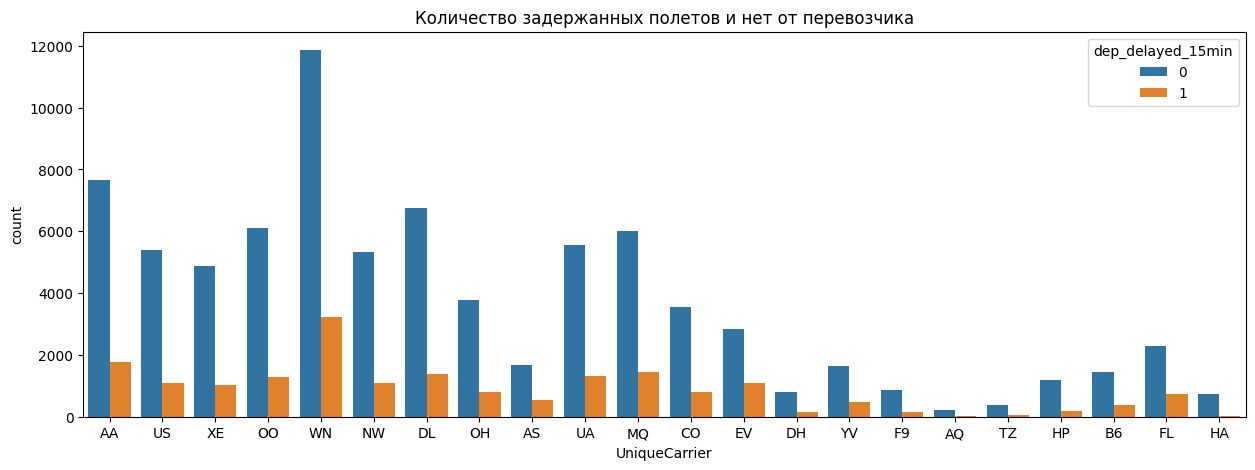

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x=df.UniqueCarrier, hue=df.dep_delayed_15min, ax=ax)
ax.set_title('Количество задержанных полетов и нет от перевозчика')

Явных зависимостей не обнаружено: количество задержанных рейсов соразмерны с общим количеством рейсов для каждого признака.

## Создание новых признаков

Для улучшения предсказательной способности будущей модели стоит добавить новые признаки.

In [ ]:
# Добавим новые признаки на основе времени вылета
df['hour'] = df['DepTime'] // 100
df.loc[df['hour'] == 24, 'hour'] = 0
df.loc[df['hour'] == 25, 'hour'] = 1
df['minute'] = df['DepTime'] % 100
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,hour,minute
0,8,21,7,1934,AA,ATL,DFW,732,0,19,34
1,4,20,3,1548,US,PIT,MCO,834,0,15,48
2,9,2,5,1422,XE,RDU,CLE,416,0,14,22
3,11,25,6,1015,OO,DEN,MEM,872,0,10,15
4,10,7,6,1828,WN,MDW,OMA,423,1,18,28


Признак DepTime был разбит на 2 дополнительных признака: час отправки и минута отправки.

In [ ]:
df_test['hour'] = df_test['DepTime'] // 100
df_test.loc[df_test['hour'] == 24, 'hour'] = 0
df_test.loc[df_test['hour'] == 25, 'hour'] = 1
df_test['minute'] = df_test['DepTime'] % 100
df_test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute
0,7,25,3,615,YV,MRY,PHX,598,6,15
1,4,17,2,739,WN,LAS,HOU,1235,7,39
2,12,2,7,651,MQ,GSP,ORD,577,6,51
3,3,25,7,1614,WN,BWI,MHT,377,16,14
4,6,6,3,1505,UA,ORD,STL,258,15,5


In [ ]:
# Добавим новые признаки на основе месяца рейса
df['summer'] = (df['Month'].isin([6, 7, 8]))
df['autumn'] = (df['Month'].isin([9, 10, 11]))
df['winter'] = (df['Month'].isin([12, 1, 2]))
df['spring'] = (df['Month'].isin([3, 4, 5]))
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,hour,minute,summer,autumn,winter,spring
0,8,21,7,1934,AA,ATL,DFW,732,0,19,34,True,False,False,False
1,4,20,3,1548,US,PIT,MCO,834,0,15,48,False,False,False,True
2,9,2,5,1422,XE,RDU,CLE,416,0,14,22,False,True,False,False
3,11,25,6,1015,OO,DEN,MEM,872,0,10,15,False,True,False,False
4,10,7,6,1828,WN,MDW,OMA,423,1,18,28,False,True,False,False


Признак Month позволил создать 4 новых признака сезона: лето, осень, зима и весна.

In [ ]:
df_test['summer'] = (df_test['Month'].isin([6, 7, 8]))
df_test['autumn'] = (df_test['Month'].isin([9, 10, 11]))
df_test['winter'] = (df_test['Month'].isin([12, 1, 2]))
df_test['spring'] = (df_test['Month'].isin([3, 4, 5]))
df_test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,summer,autumn,winter,spring
0,7,25,3,615,YV,MRY,PHX,598,6,15,True,False,False,False
1,4,17,2,739,WN,LAS,HOU,1235,7,39,False,False,False,True
2,12,2,7,651,MQ,GSP,ORD,577,6,51,False,False,True,False
3,3,25,7,1614,WN,BWI,MHT,377,16,14,False,False,False,True
4,6,6,3,1505,UA,ORD,STL,258,15,5,True,False,False,False


In [ ]:
# Добавим новый признак Weekend для учета выходного дня
df['Weekend'] = df.DayOfWeek.apply(lambda x: x > 5)
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,hour,minute,summer,autumn,winter,spring,Weekend
0,8,21,7,1934,AA,ATL,DFW,732,0,19,34,True,False,False,False,True
1,4,20,3,1548,US,PIT,MCO,834,0,15,48,False,False,False,True,False
2,9,2,5,1422,XE,RDU,CLE,416,0,14,22,False,True,False,False,False
3,11,25,6,1015,OO,DEN,MEM,872,0,10,15,False,True,False,False,True
4,10,7,6,1828,WN,MDW,OMA,423,1,18,28,False,True,False,False,True


Из признака DayOfWeek был создан новый признак: выходной день.

In [ ]:
df_test['Weekend'] = df_test.DayOfWeek.apply(lambda x: x > 5)
df_test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,summer,autumn,winter,spring,Weekend
0,7,25,3,615,YV,MRY,PHX,598,6,15,True,False,False,False,False
1,4,17,2,739,WN,LAS,HOU,1235,7,39,False,False,False,True,False
2,12,2,7,651,MQ,GSP,ORD,577,6,51,False,False,True,False,True
3,3,25,7,1614,WN,BWI,MHT,377,16,14,False,False,False,True,True
4,6,6,3,1505,UA,ORD,STL,258,15,5,True,False,False,False,False


In [ ]:
# Выведем все обозначения аэропортов в датасете
a = list(df.Origin.unique())
a.extend(list(df.Dest.unique()))
print(set(a))

{'TUP', 'DCA', 'MCI', 'SAV', 'ACV', 'MBS', 'TYR', 'PIA', 'DAB', 'SRQ', 'CDC', 'LEX', 'FWA', 'MRY', 'RIC', 'SGF', 'ALB', 'PNS', 'VCT', 'GGG', 'EGE', 'TOL', 'LCH', 'SUN', 'MCO', 'HNL', 'MOD', 'MIA', 'BDL', 'LBB', 'TUS', 'BTR', 'ATW', 'TUL', 'MQT', 'PIH', 'ILG', 'CLT', 'HOU', 'CVG', 'TEX', 'SPI', 'DRO', 'FLO', 'EYW', 'PFN', 'DTW', 'GEG', 'PDX', 'ORF', 'TWF', 'SJC', 'ISO', 'STX', 'DFW', 'FCA', 'AKN', 'SAN', 'IAD', 'PWM', 'MGM', 'ADQ', 'HTS', 'LAN', 'CAE', 'MSY', 'BLI', 'DHN', 'MDW', 'GFK', 'IAH', 'HDN', 'ELP', 'FAT', 'BIL', 'ILM', 'GST', 'SEA', 'ONT', 'LIH', 'OAJ', 'LYH', 'ABQ', 'LSE', 'EVV', 'HSV', 'ROA', 'CHS', 'SOP', 'BIS', 'SNA', 'OXR', 'BTM', 'ROC', 'CLL', 'MAF', 'WRG', 'RSW', 'DLH', 'DAL', 'HRL', 'MLU', 'CLE', 'LRD', 'SBA', 'CWA', 'DBQ', 'GRK', 'LWB', 'BUF', 'FNT', 'GRR', 'PVD', 'KTN', 'CMH', 'COS', 'GRB', 'SHV', 'LAS', 'PHF', 'SAT', 'LGA', 'ASE', 'ADK', 'LFT', 'SBN', 'ISP', 'SGU', 'JAN', 'APF', 'TTN', 'PIE', 'IND', 'MLB', 'STL', 'MEI', 'AVL', 'LWS', 'GSP', 'CRP', 'IDA', 'PHX', 'MSN'

In [ ]:
# Создадим словарь с регионом и принадлежащим ему аэропортам
airports_by_region = {
    "Аляска": ["ANC", "BRW", "ADQ", "BET", "CDV", "DRO", "FAI", "GST", "JNU", "KOA", "KTN", "OME", "OTZ", "PSP", "SC", "SIT", "WR", "YAK"],
    "Западное побережье": ["BFL", "BUR", "FAT", "LAX", "LGB", "MFR", "MRY", "OAK", "ONT", "PSP", "RDD", "SAN", "SBA", "SBP", "SFO", "SMF", "SMX", "SNA",
                           "SJC", "FLG", "IFP", "PHX", "TUS", "YUM", "ASE", "COS", "DEN", "GJT", "MTJ", "BOI", "IDA", "TWF", "EUG", "MFR", "PDX", "RDM", "SEA"],
    "Юго-Запад": ["ABI", "AMA", "AUS", "BPT", "BRO", "CLL", "CRP", "DAL", "DFW", "ELP", "GRK", "HOU", "HRL", "IAH", "LBB", "LRD", "MAF", "MFE", "SAT", "SJT", "SPS", "TYR"],
    "Средний Запад": ["CID", "DBQ", "DSM", "SUX", "ICT", "MCI", "LEX", "LNK", "SDF", "BMI", "MDW", "MLI", "ORD", "PIA", "RFD", "SPI", "BIS", "FAR", "MOT", "BIL",
                      "BZN", "FCA", "GTF", "HLN", "MSO", "DLH", "MSP", "RST", "GRR", "LAN", "MBT", "MKG", "MQT", "AZO", "FNT", "GRR", "DTW"],
    "Северо-Восток": ["ALB", "BUF", "ERI", "ISP", "JFK", "LGA", "ROC", "SWF", "BDL", "HVN", "BOS", "ORH", "PVD", "BGR", "PWM", "EWR", "ACY", "TTN", "BWI", "SBY",
                      "PHL", "PIT", "SCE", "AVP", "MDT"],
    "Пуэрто-Рико": ["BQN", "PSE", "SJU", "SIG"],
    "Виргинские острова": ["STT", "STX"]
}


In [ ]:
# Функция для заполнения региона
def regionByCode(code):
  for region, airports in airports_by_region.items():
    if code in airports:
      return region
  return 'Юго-Восток'

# Создадим новые признаки с регионами места отправки и места назначения
df['Origin_region'] = df.Origin.apply(regionByCode)
df['Dest_region'] = df.Dest.apply(regionByCode)
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,hour,minute,summer,autumn,winter,spring,Origin_region,Dest_region
0,8,21,7,1934,AA,ATL,DFW,732,0,19,34,True,False,False,False,Юго-Восток,Юго-Запад
1,4,20,3,1548,US,PIT,MCO,834,0,15,48,False,False,False,True,Северо-Восток,Юго-Восток
2,9,2,5,1422,XE,RDU,CLE,416,0,14,22,False,True,False,False,Юго-Восток,Юго-Восток
3,11,25,6,1015,OO,DEN,MEM,872,0,10,15,False,True,False,False,Западное побережье,Юго-Восток
4,10,7,6,1828,WN,MDW,OMA,423,1,18,28,False,True,False,False,Средний Запад,Юго-Восток


На основе признаков Origin и Dest были созданы признаки региона отправки и региона назначения.

In [ ]:
df_test['Origin_region'] = df_test.Origin.apply(regionByCode)
df_test['Dest_region'] = df_test.Dest.apply(regionByCode)
df_test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,summer,autumn,winter,spring,Weekend,Origin_region,Dest_region
0,7,25,3,615,YV,MRY,PHX,598,6,15,True,False,False,False,False,Западное побережье,Западное побережье
1,4,17,2,739,WN,LAS,HOU,1235,7,39,False,False,False,True,False,Юго-Восток,Юго-Запад
2,12,2,7,651,MQ,GSP,ORD,577,6,51,False,False,True,False,True,Юго-Восток,Средний Запад
3,3,25,7,1614,WN,BWI,MHT,377,16,14,False,False,False,True,True,Северо-Восток,Юго-Восток
4,6,6,3,1505,UA,ORD,STL,258,15,5,True,False,False,False,False,Средний Запад,Юго-Восток


In [ ]:
df.Distance.describe()

,Distance
count,100000.00000
mean,729.39716
std,574.61686
min,30.00000
25%,317.00000
50%,575.00000
75%,957.00000
max,4962.00000


In [ ]:
# Функция для категоризации дальности полета
def distance_cat(distance):
  if distance <= 1000:
    return 'short'
  elif distance <= 2500:
    return 'mid'
  else:
    return 'long'

# Добавим новый признак категории полета
df['distance_cat'] = df.Distance.apply(distance_cat)
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,hour,minute,summer,autumn,winter,spring,Origin_region,Dest_region,distance_cat
0,8,21,7,1934,AA,ATL,DFW,732,0,19,34,True,False,False,False,Юго-Восток,Юго-Запад,short
1,4,20,3,1548,US,PIT,MCO,834,0,15,48,False,False,False,True,Северо-Восток,Юго-Восток,short
2,9,2,5,1422,XE,RDU,CLE,416,0,14,22,False,True,False,False,Юго-Восток,Юго-Восток,short
3,11,25,6,1015,OO,DEN,MEM,872,0,10,15,False,True,False,False,Западное побережье,Юго-Восток,short
4,10,7,6,1828,WN,MDW,OMA,423,1,18,28,False,True,False,False,Средний Запад,Юго-Восток,short


Был добавлен новый признак distance_cat на основе признака Distance. Новый признак говорит о категории дальности полета: короткая дистанция, средняя дистанция и длинная дистанция.

In [ ]:
df_test['distance_cat'] = df_test.Distance.apply(distance_cat)
df_test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,summer,autumn,winter,spring,Weekend,Origin_region,Dest_region,distance_cat
0,7,25,3,615,YV,MRY,PHX,598,6,15,True,False,False,False,False,Западное побережье,Западное побережье,short
1,4,17,2,739,WN,LAS,HOU,1235,7,39,False,False,False,True,False,Юго-Восток,Юго-Запад,mid
2,12,2,7,651,MQ,GSP,ORD,577,6,51,False,False,True,False,True,Юго-Восток,Средний Запад,short
3,3,25,7,1614,WN,BWI,MHT,377,16,14,False,False,False,True,True,Северо-Восток,Юго-Восток,short
4,6,6,3,1505,UA,ORD,STL,258,15,5,True,False,False,False,False,Средний Запад,Юго-Восток,short


## Создание моделей

Преобразуем датасеты при помощи one-hot кодирования.

In [ ]:
df_oh = pd.get_dummies(df)
df_test_oh = pd.get_dummies(df_test)

Разобьем датасет на тренировочную и тестовую выборку.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_oh.drop('dep_delayed_15min', axis=1),
    df_oh.dep_delayed_15min,
    test_size=0.2,
    stratify=df_oh.dep_delayed_15min,
    random_state=42
    )

Проверим некоторые модели классификации на качество предсказаний.

In [ ]:
modelsDict = {'gbc': GradientBoostingClassifier(random_state=42), 'lrc': LogisticRegression(random_state=42, max_iter=500),
              'rfc': RandomForestClassifier(max_depth=6, random_state=42), 'dtc': DecisionTreeClassifier(max_depth=6, random_state=42),
              'CatBoost': CatBoostClassifier(silent=True, random_state=42, task_type='GPU'), 'XGBoost': XGBClassifier(random_state=42)}

def test_models(models):
    for model_name, model in models.items():
      model.fit(X_train, y_train)
      proba = model.predict_proba(X_test)[:, 1]
      print(f'{model_name}: {roc_auc_score(y_test, proba)}')


test_models(modelsDict)

gbc: 0.7297416494638311


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


lrc: 0.6994646426659281
rfc: 0.7038071252955518
dtc: 0.7018815443803159
CatBoost: 0.7453775218346738
XGBoost: 0.7496564094683642


Модели CatBoost и XGBoost показали себя лучше остальных на гиперпараметрах по умолчанию.

Для дальнейшей оптимизации была выбрана модель CatBoost по двум причинам:
1. Catboost автоматически обрабатывает категориальные признаки, которых в нашем датасете много.
2. В тестовом датасете могут оказаться записи которые содержат новые категориальные признаки. Модель Catboost способна с этим справиться.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('dep_delayed_15min', axis=1),
    df.dep_delayed_15min,
    test_size=0.2,
    stratify=df.dep_delayed_15min,
    random_state=42
    )

In [ ]:
df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'dep_delayed_15min', 'hour', 'minute',
       'summer', 'autumn', 'winter', 'spring', 'Weekend', 'Origin_region',
       'Dest_region', 'distance_cat'],
      dtype='object')

In [ ]:
# Составим словарь различных гиперпараметров модели
param_grid = {
    'depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [1000, 2000]
}
# В модели CatBoostClasifier укажем позиции категориальных признаков
grid_search = GridSearchCV(
    estimator=CatBoostClassifier(silent=True, random_seed=42, cat_features=[4, 5, 6, 15, 16, 17], task_type='GPU'),
    param_grid=param_grid, # Словарь с гиперпараметрами
    cv=3, # Разрезы кросс-валидации
    scoring='roc_auc', # Метрика - ROC AUC
    n_jobs=-1 # Воспользуемся всеми ядрами нашей системы
    )

grid_search.fit(X_train, y_train)

# Вывод лучших гиперпараметров
print("Лучшие гиперпараметры:", grid_search.best_params_)

# Вывод лучшей метрики
print("Лучшая точность:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Лучшие гиперпараметры: {'depth': 6, 'learning_rate': 0.05, 'n_estimators': 2000}
Лучшая точность: 0.7454306736220274


Лучшие гиперпараметры: {'depth': 6, 'learning_rate': 0.05, 'n_estimators': 2000}
Лучшая точность: 0.7454306736220274

In [ ]:
# Проверим модель на валидационной выборке
proba = best_model.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, proba))

0.7565865371339402


# Сабмит результатов

In [ ]:
# Предскажем вероятности для тестовой выборки
proba = best_model.predict_proba(df_test)[:, 1]

In [ ]:
# Сохраним результаты в DataFrame
out = pd.DataFrame({'dep_delayed_15min' : proba})
out.index.name = 'id'
out

,dep_delayed_15min
id,
0,0.033687
1,0.046537
2,0.044526
3,0.327819
4,0.213039
...,...
99995,0.043006
99996,0.193973
99997,0.227769


In [ ]:
# Выгрузим полученный датафрейм
out.to_csv('file.csv')

Полученный результат в соревновании Kaggle:

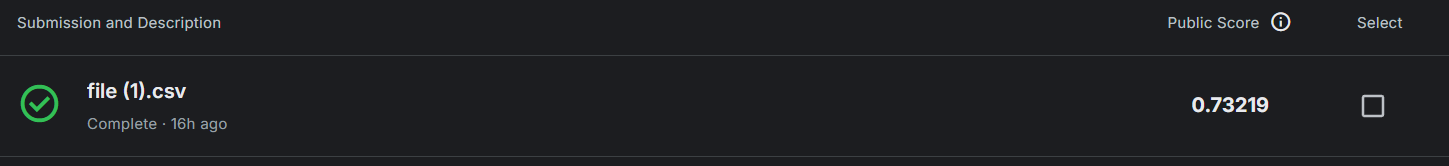